## House Prices Thinkful Challenge

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from  sklearn.linear_model import LassoCV
from scipy.stats.mstats import winsorize

import warnings
warnings.filterwarnings('ignore')



In [2]:
#load data set
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices_df = pd.read_sql_query('select * from houseprices', con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [4]:
#investigate data
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [5]:
houseprices_df.shape #here we can see we have 1460 rows and 81 columns

(1460, 81)

In [6]:
#let's look at object types
houseprices_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [7]:
houseprices_df1= houseprices_df.copy()  # make a copy. It is good practice just in case we need to see original data

In [8]:
null= houseprices_df1.isnull().sum()*100/len(houseprices_df1)
null.sort_values(ascending=False).head(20)

poolqc          99.520548
miscfeature     96.301370
alley           93.767123
fence           80.753425
fireplacequ     47.260274
lotfrontage     17.739726
garagecond       5.547945
garagetype       5.547945
garageyrblt      5.547945
garagefinish     5.547945
garagequal       5.547945
bsmtexposure     2.602740
bsmtfintype2     2.602740
bsmtfintype1     2.534247
bsmtcond         2.534247
bsmtqual         2.534247
masvnrarea       0.547945
masvnrtype       0.547945
electrical       0.068493
utilities        0.000000
dtype: float64

### I want to separate my numerical values from my categorical values.  

In [9]:
#looking at null values
num_cols= houseprices_df1.select_dtypes(include=['int', 'float'])
num_cols.isnull().sum().sort_values(ascending=False).head(5)

lotfrontage     259
garageyrblt      81
masvnrarea        8
bsmtfinsf1        0
lowqualfinsf      0
dtype: int64

In [10]:
# Create correlation matrix
c=num_cols.corr().abs()

# Select upper triangle of correlation matrix
upper = c.where(np.triu(np.ones(c.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
num_cols.drop(num_cols[to_drop], axis=1)


,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
5,6,50,85.0,14115,5,5,1993,1995,0.0,732,...,40,30,0,320,0,0,700,10,2009,143000
6,7,20,75.0,10084,8,5,2004,2005,186.0,1369,...,255,57,0,0,0,0,0,8,2007,307000
7,8,60,NaN,10382,7,6,1973,1973,240.0,859,...,235,204,228,0,0,0,350,11,2009,200000
8,9,50,51.0,6120,7,5,1931,1950,0.0,0,...,90,0,205,0,0,0,0,4,2008,129900
9,10,190,50.0,7420,5,6,1939,1950,0.0,851,...,0,4,0,0,0,0,0,1,2008,118000


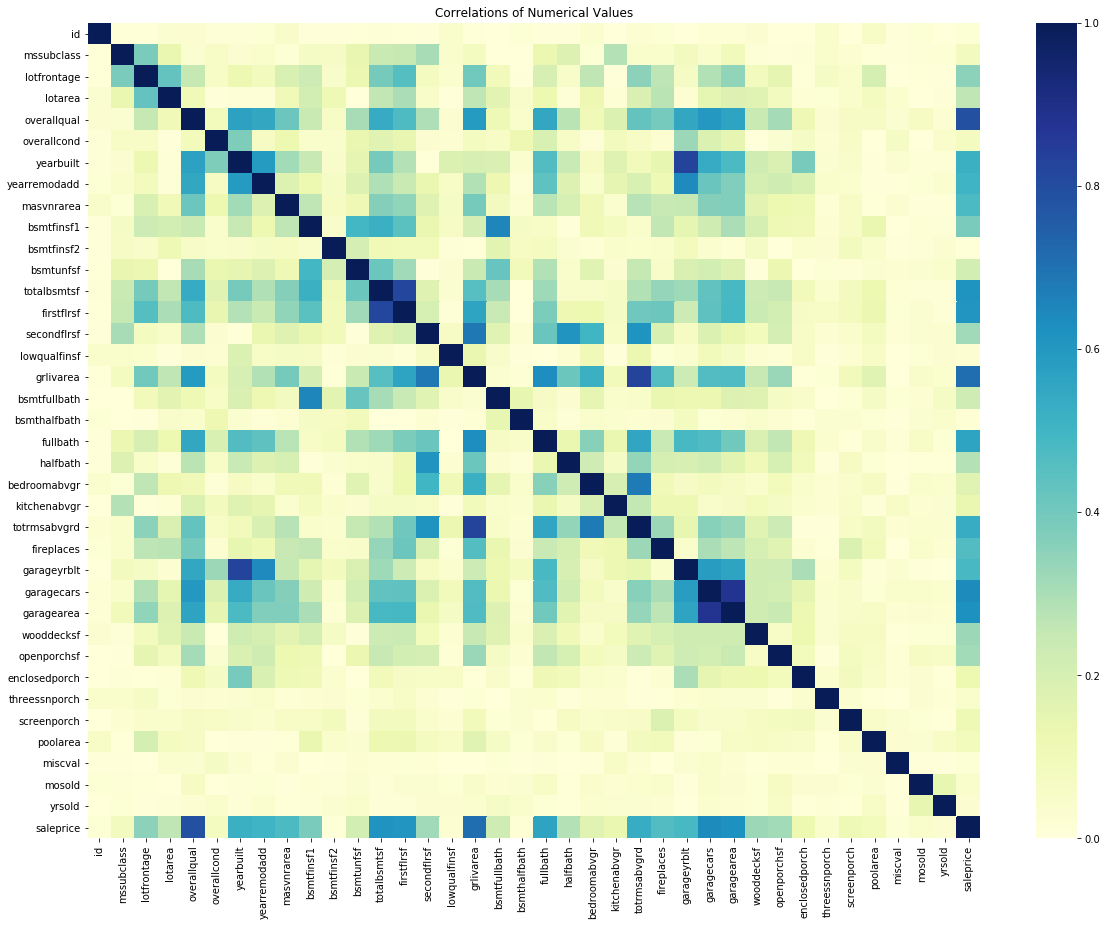

In [11]:
plt.figure(figsize=(20,15))
sns.heatmap(c, cmap="YlGnBu")
plt.title('Correlations of Numerical Values')
plt.show()

In [12]:
#looking at correlation
num_corr=num_cols.iloc[:,1:].corr().loc[:,"saleprice"].abs()
num_corr.sort_values(ascending= False).head(7)

saleprice      1.000000
overallqual    0.790982
grlivarea      0.708624
garagecars     0.640409
garagearea     0.623431
totalbsmtsf    0.613581
firstflrsf     0.605852
Name: saleprice, dtype: float64

### Our first five features that are correlated with saleprice are overallqual, grlivarea, garagecars, garagearea and totalbsmtsf.  We will use these features in our model. Now let's look at the categorical values to determine which ones we can use.

In [13]:
cat_cols= houseprices_df.select_dtypes(exclude=['int', 'float'])
cat_cols.isnull().sum().sort_values(ascending=False).head(20)

poolqc          1453
miscfeature     1406
alley           1369
fence           1179
fireplacequ      690
garagecond        81
garagequal        81
garagefinish      81
garagetype        81
bsmtfintype2      38
bsmtexposure      38
bsmtfintype1      37
bsmtqual          37
bsmtcond          37
masvnrtype         8
electrical         1
condition2         0
condition1         0
neighborhood       0
landslope          0
dtype: int64

### Some of the features that have a lot of missing values,  are not really missing data, rather after inspection, it appears that they are just non-existant or the property does not have it (example, pool, garage, etc.). We only have 14 categorical  and 3 continuous variables that have missing data. For now, we will just use variables without missing values. 

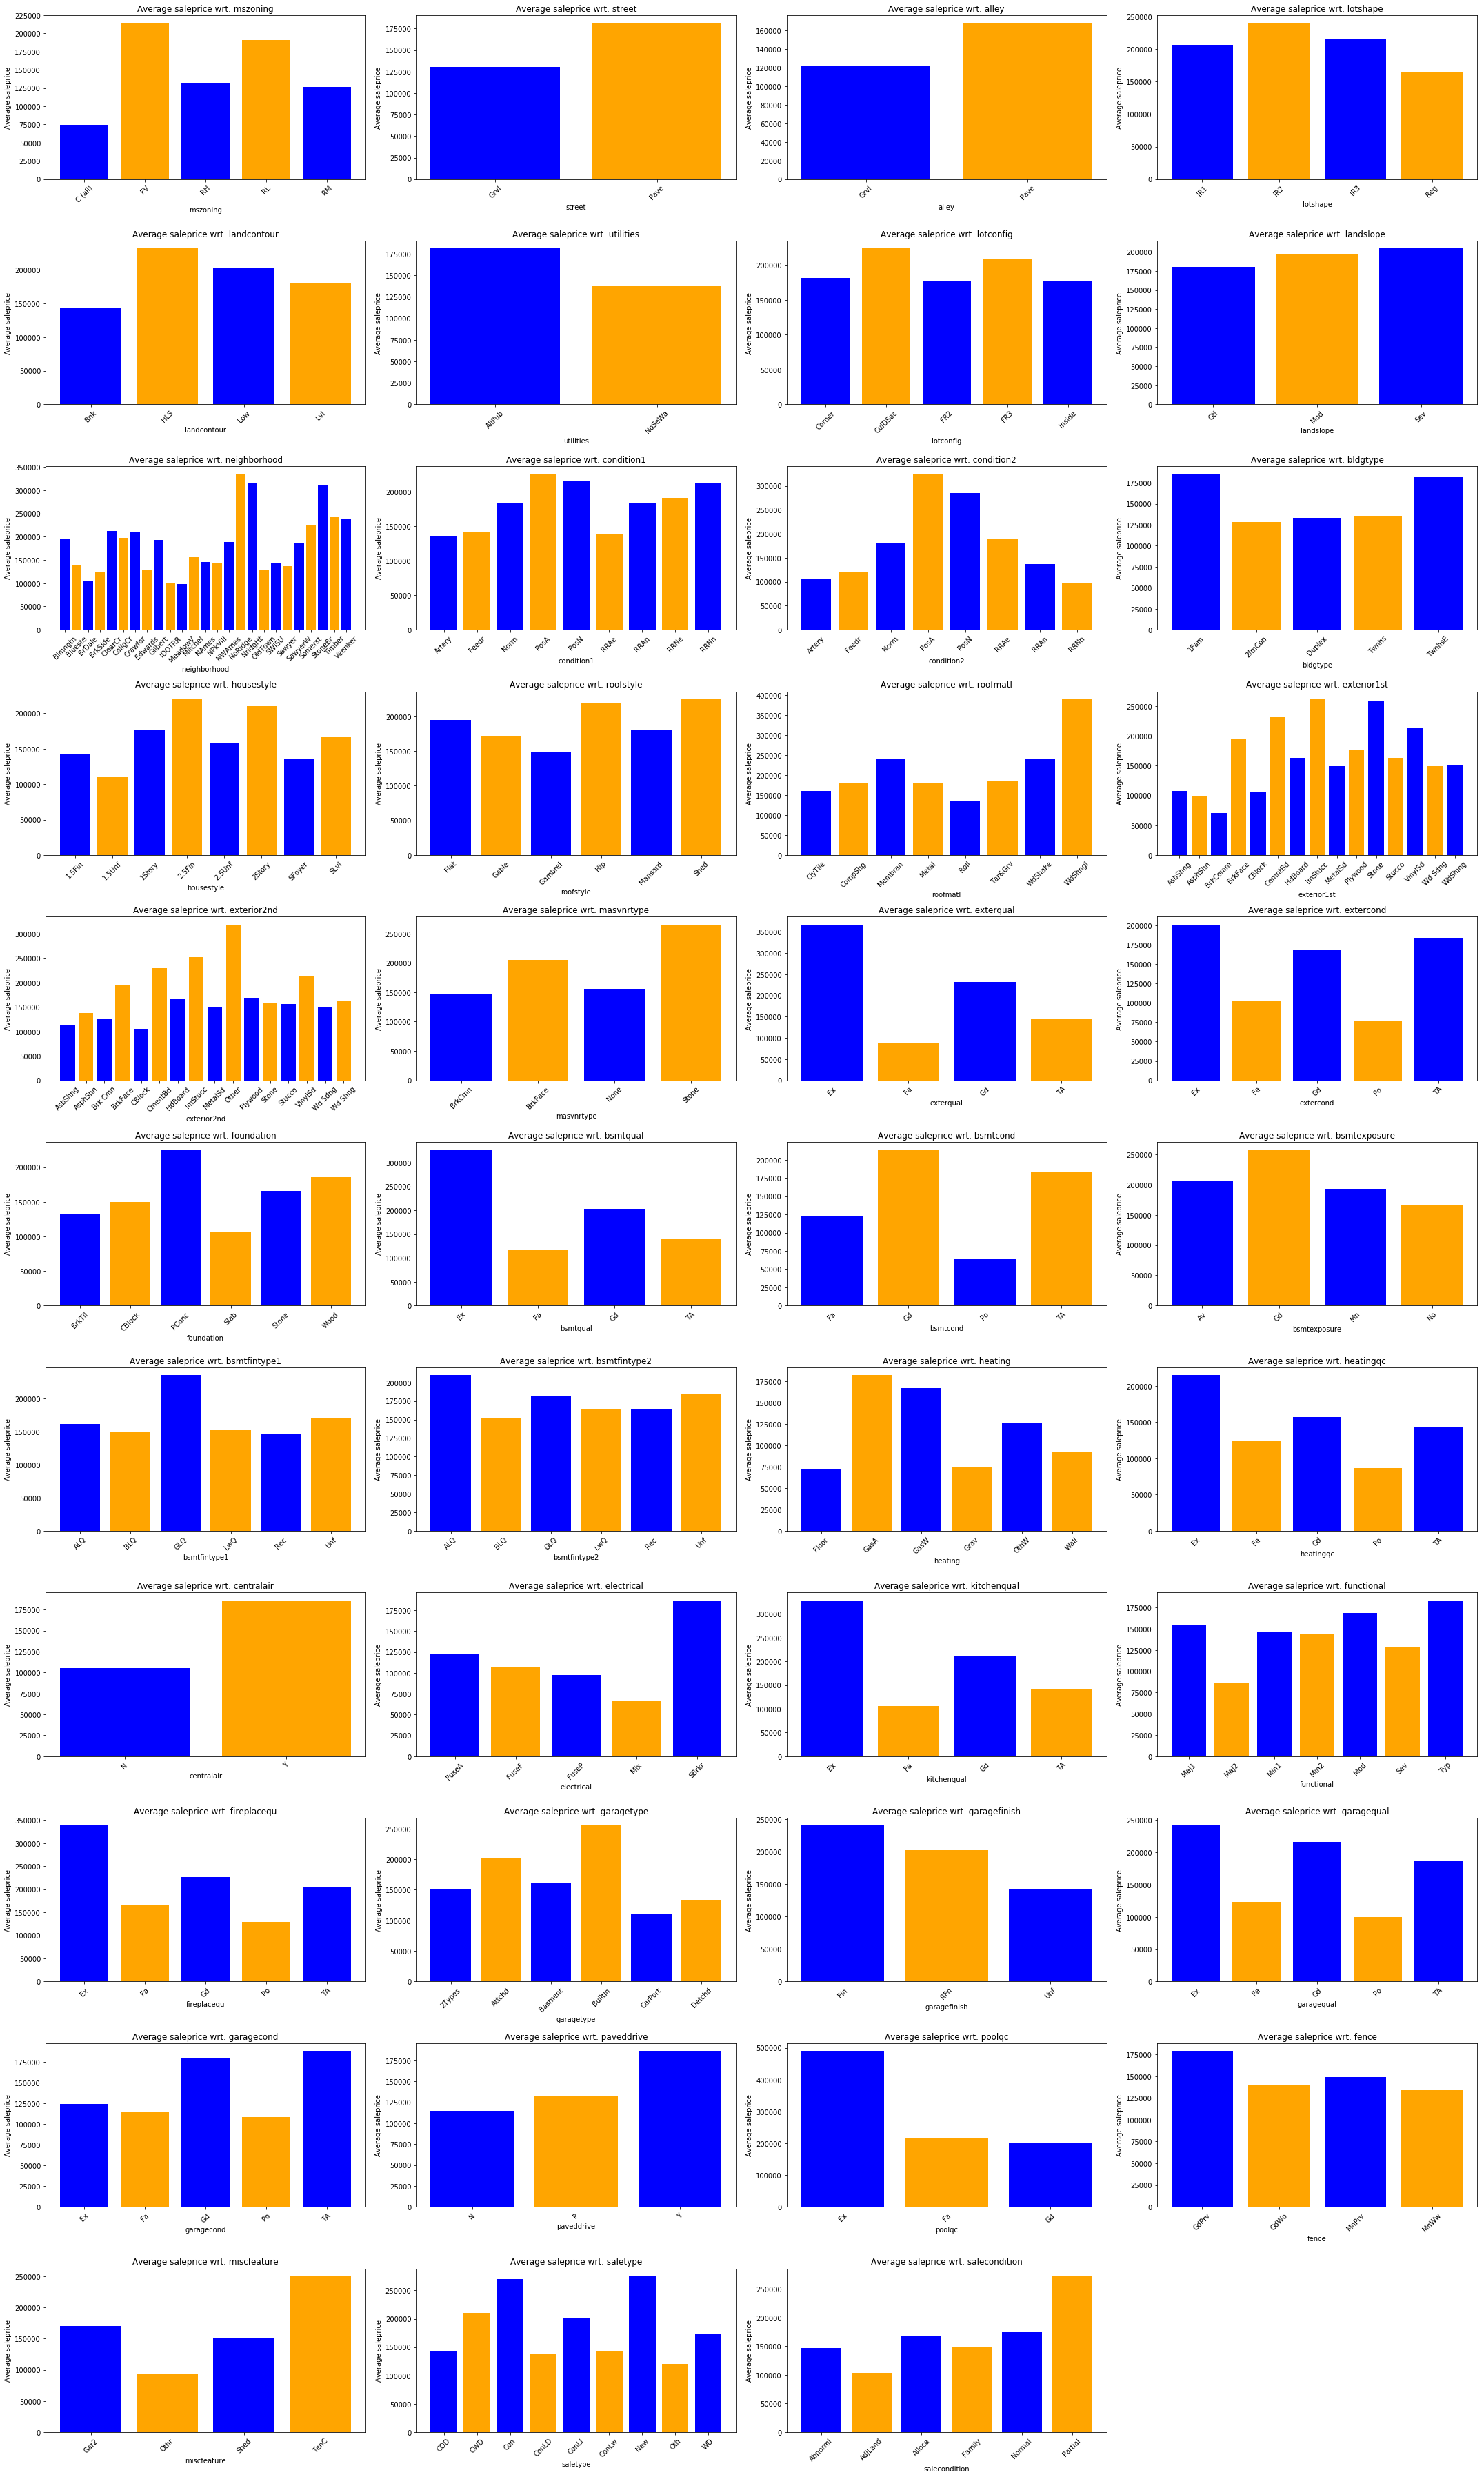

In [14]:
### Let's look at the categorical values with a bar plot and see what we can use. 

cat_cols = houseprices_df.select_dtypes(['object']).columns

plt.figure(figsize=(30,50))

for i, column in enumerate(cat_cols):
    plt.subplot(11,4,i+1)
    plt.bar(houseprices_df.groupby(column)['saleprice'].mean().index, houseprices_df.groupby(column)['saleprice'].mean(), color=['blue', 'orange'])
    plt.title('Average saleprice wrt. {}'.format(column))
    plt.ylabel('Average saleprice')
    plt.xlabel(column)
    plt.xticks(rotation='45')
plt.tight_layout()
plt.show()

### I want to look at the selected target (saleprice) distribution

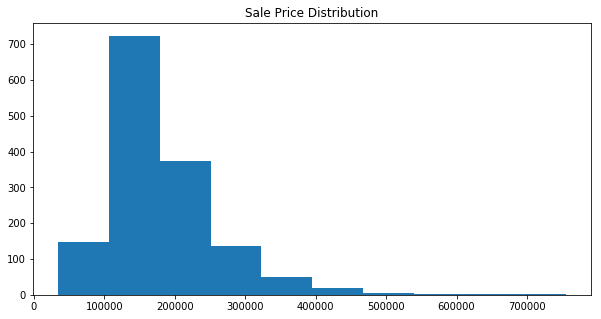

In [15]:

plt.figure(figsize=(10,5))
plt.hist(houseprices_df1.saleprice)
plt.title('Sale Price Distribution')
plt.show()
#saleprice is skewed to the right. 

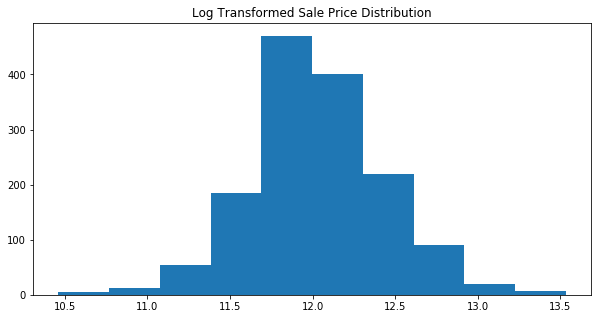

In [16]:
#Let's make use np.log to make distribution normal
houseprices_df1['log_sale_price'] = np.log1p(houseprices_df1.saleprice)


plt.figure(figsize=(10,5))

plt.hist(houseprices_df1.log_sale_price)
plt.title('Log Transformed Sale Price Distribution')
plt.show()

### Splitting train and test data.

In [17]:
# For my categorical values, I will use condition2 and street
houseprices_df1 = pd.concat([houseprices_df1,pd.get_dummies(houseprices_df1.condition2, prefix="condition2", drop_first=True)], axis=1)
houseprices_df1 = pd.concat([houseprices_df1,pd.get_dummies(houseprices_df1.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(houseprices_df1.condition2, prefix="condition2", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df1.street, prefix="street", drop_first=True).columns)


In [18]:
X = houseprices_df1[['overallqual', 'grlivarea', 'garagecars', 
                    'garagearea', 'totalbsmtsf',
                    'lotarea', 'overallcond'] + dummy_column_names]

Y = houseprices_df1.log_sale_price

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


### Linear Regression Model 1

In [19]:
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         log_sale_price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     357.0
Date:                Thu, 08 Aug 2019   Prob (F-statistic):               0.00
Time:                        00:16:37   Log-Likelihood:                 399.57
No. Observations:                1168   AIC:                            -769.1
Df Residuals:                    1153   BIC:                            -693.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.1534      0.149  

- Our R squared is 81.3 % and adj. R squared is 81%. 
- We have an F statistic of 357.0 with a significant p value of less than 0.05. 
- Our AIC is -769.1 and BIC is -693.2
- When we look at overallqual, grlivarea, garagecars, totalbsmtsf, lotarea, overallcond, condition2_PosA and condition2_PosN, they all display significant p-values at 0.00.

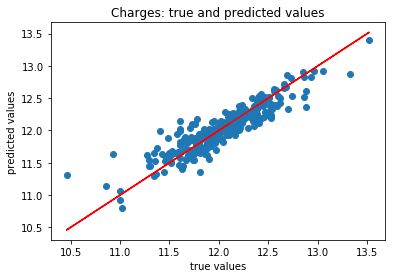

Mean absolute error of the prediction is: 0.12422192990745298
Mean squared error of the prediction is: 0.02906707551549408
Root mean squared error of the prediction is: 0.17049069040711307
Mean absolute percentage error of the prediction is: 1.0409627550789158


In [20]:
#Let's look at the plot and make predictions
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


- Let's see if we can lower our MAE, MSEP, RMSE and MAPE more on the next model. 


In [21]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))

R-squared of the model in the training set is: 0.8125538769730215
-----Test set statistics-----
R-squared of the model in the test set is: 0.8256801558436628


- Little difference in seen between train and test R squared. We do not have an overfit! Let's take a look at our next model 

### Linear Regression Model 2
#### For this model, we remove features that are not statistically significant. I'll also choose another feature to be included. 

In [22]:
# I chose to add lotconfig this time. Creating dummies.
houseprices_df1 = pd.concat([houseprices_df1,pd.get_dummies(houseprices_df1.lotconfig, prefix="lotconfig", drop_first=True)], axis=1)
dummy_column_names2 = list(pd.get_dummies(houseprices_df1.lotconfig, prefix="lotconfig", drop_first=True).columns)


In [23]:
X = houseprices_df1[['overallqual', 'grlivarea', 'garagecars', 
                     'totalbsmtsf', 'lotarea', 'overallcond','condition2_PosA', 'condition2_PosN' ] + dummy_column_names2]
                    
Y = houseprices_df1.log_sale_price
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [24]:
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         log_sale_price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     458.1
Date:                Thu, 08 Aug 2019   Prob (F-statistic):               0.00
Time:                        00:16:38   Log-Likelihood:                 402.20
No. Observations:                1168   AIC:                            -780.4
Df Residuals:                    1156   BIC:                            -719.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.3333      0.03

- This is slightly better. The lotconfig_CulDSac is statistically significant. We will keep this feature and get rid of the other lot features. R squared remains at 81.3% and R adjusted squared went up to 81.2%. 
- F statistic is 458.1 and has a significant pvalue. 
- AIC and BIC -780.4 and -719.6. 


### Model 3

In [25]:
#This model, we got rid of lot features except statistically significant one (lotconfig_CulDSac). 
X = houseprices_df1[['overallqual', 'grlivarea', 'garagecars', 
                     'totalbsmtsf', 'lotarea', 'overallcond', 'lotconfig_CulDSac', 'condition2_PosA', 'condition2_PosN']]
                    
Y = houseprices_df1.log_sale_price
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [26]:
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         log_sale_price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     629.0
Date:                Thu, 08 Aug 2019   Prob (F-statistic):               0.00
Time:                        00:16:38   Log-Likelihood:                 400.28
No. Observations:                1168   AIC:                            -782.6
Df Residuals:                    1159   BIC:                            -737.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.3533      0.03

### What else can I do to improve my model? Next we look at feature distributions.

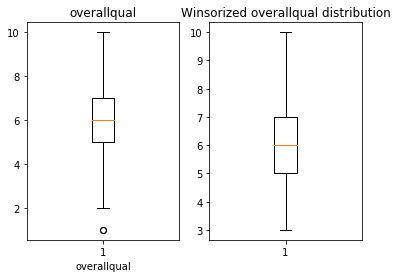

In [27]:
#Looking for outliers
plt.subplot(1,2,1)
plt.boxplot(houseprices_df1.overallqual)
plt.title('overallqual')
plt.xlabel('overallqual')

#Let's winsorize features then try our model again. 
houseprices_df1['win_overallqual'] = winsorize(houseprices_df1.overallqual, (0.01, 0))
plt.subplot(1,2,2)
plt.boxplot(houseprices_df1.win_overallqual)
plt.title('Winsorized overallqual distribution')
plt.show()


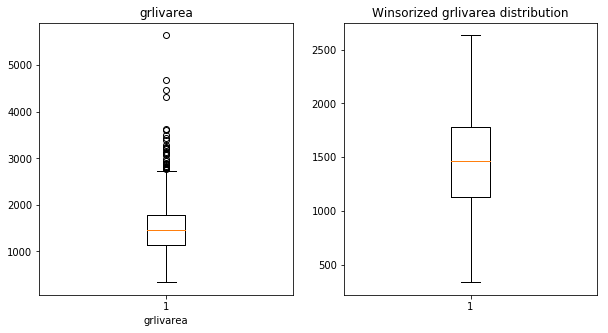

In [28]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot(houseprices_df1.grlivarea)
plt.title('grlivarea')
plt.xlabel('grlivarea')


houseprices_df1['win_grlivarea'] = winsorize(houseprices_df1.grlivarea, (0,0.03))
plt.subplot(1,2,2)
plt.boxplot(houseprices_df1.win_grlivarea)
plt.title('Winsorized grlivarea distribution')
plt.show()

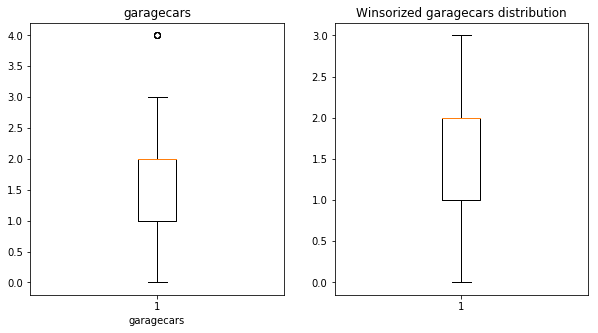

In [29]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot(houseprices_df1.garagecars)
plt.title('garagecars')
plt.xlabel('garagecars')


houseprices_df1['win_garagecars'] = winsorize(houseprices_df1.garagecars, (0,0.1))
plt.subplot(1,2,2)
plt.boxplot(houseprices_df1.win_garagecars)
plt.title('Winsorized garagecars distribution')
plt.show()

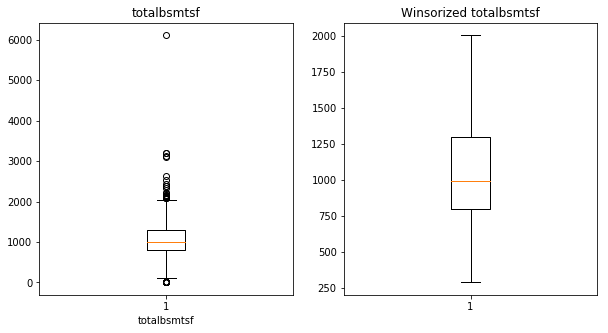

In [30]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot(houseprices_df1.totalbsmtsf)
plt.title('totalbsmtsf')
plt.xlabel('totalbsmtsf')


houseprices_df1['win_totalbsmtsf'] = winsorize(houseprices_df1.totalbsmtsf, (0.03,.02))
plt.subplot(1,2,2)
plt.boxplot(houseprices_df1.win_totalbsmtsf)
plt.title('Winsorized totalbsmtsf')
plt.show()

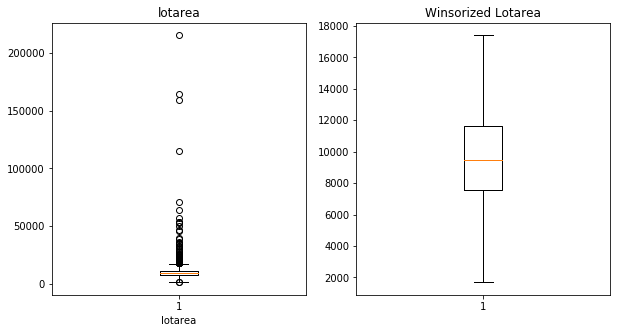

In [31]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot(houseprices_df1.lotarea)
plt.title('lotarea')
plt.xlabel('lotarea')


houseprices_df1['win_lotarea'] = winsorize(houseprices_df1.lotarea, (0.01,0.05))
plt.subplot(1,2,2)
plt.boxplot(houseprices_df1.win_lotarea)
plt.title('Winsorized Lotarea')
plt.show()

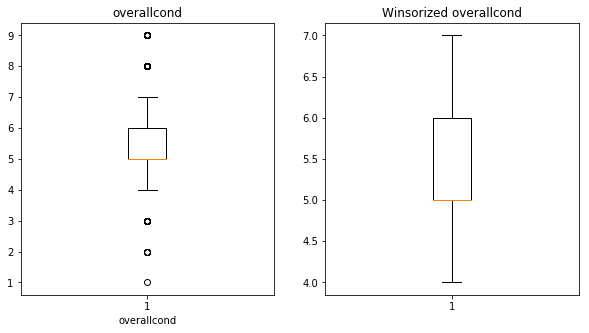

In [32]:

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot(houseprices_df1.overallcond)
plt.title('overallcond')
plt.xlabel('overallcond')


houseprices_df1['win_overallcond'] = winsorize(houseprices_df1.overallcond, (0.03,0.07))
plt.subplot(1,2,2)
plt.boxplot(houseprices_df1.win_overallcond)
plt.title('Winsorized overallcond')
plt.show()

### Model 4

In [33]:
#Excited to try this one! 
X = houseprices_df1[['win_overallqual', 'win_grlivarea', 'win_garagecars', 
                     'win_totalbsmtsf', 'win_lotarea', 'win_overallcond', 'lotconfig_CulDSac', 'condition2_PosA', 'condition2_PosN']]
                
Y = houseprices_df1.log_sale_price
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [34]:
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         log_sale_price   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     772.1
Date:                Thu, 08 Aug 2019   Prob (F-statistic):               0.00
Time:                        00:16:41   Log-Likelihood:                 499.43
No. Observations:                1168   AIC:                            -980.9
Df Residuals:                    1159   BIC:                            -935.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.1587      0.04

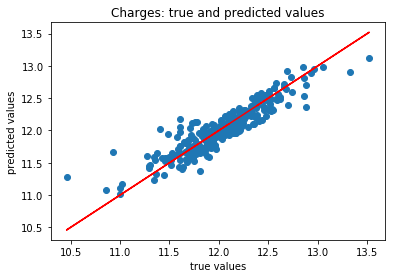

Mean absolute error of the prediction is: 0.1223192149937152
Mean squared error of the prediction is: 0.02802328415819773
Root mean squared error of the prediction is: 0.16740156557869385
Mean absolute percentage error of the prediction is: 1.023924011841603


In [35]:
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


In [36]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))

R-squared of the model in the training set is: 0.8420159057896973
-----Test set statistics-----
R-squared of the model in the test set is: 0.83193993752144


- Our R squared increased from 81% to 84.2%!
- There isn't much difference between our R squared from the train set and the test set which means we are not overfitting!
- MEA, MSE, RMSE, and MAPE are lowered as well from previous. 
- This model is the best one so far. 
- Now let's see if it will be better to have other models such as lasso, ridge and elasticnet.

### Ridge with CV

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

alphas = [np.power(10.0,p) for p in np.arange(-10,50,1)]
# I chose 10 k folds. 
ridge_cv = RidgeCV(alphas=alphas, cv=10)

ridge_cv.fit(X_train, y_train)

y_train_preds = ridge_cv.predict(X_train)
y_test_preds = ridge_cv.predict(X_test)

print('Best alpha value is {}'.format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

Best alpha value is 10.0
R-squared of the model in training set is: 0.8395160030955867
-----Test set statistics-----
R-squared of the model in test set is: 0.8316611756205653
Mean absolute error of the prediction is: 0.12222936814184425
Mean squared error of the prediction is: 0.02806976649222261
Root mean squared error of the prediction is: 0.16754034287962588
Mean absolute percentage error of the prediction is: 1.0231969639796696


### Lasso with CV

In [38]:

lasso_cv = LassoCV(alphas=alphas, cv=10)
lasso_cv.fit(X_train, y_train)

y_train_preds = lasso_cv.predict(X_train)
y_test_preds = lasso_cv.predict(X_test)

print('Best alpha value is {}'.format(lasso_cv.alpha_))
print('R-squared of the model on the training set is: {}'.format(lasso_cv.score(X_train, y_train)))
print('---------Test set statistic--------------')
print('R-squared of the model on the test set is: {}'.format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

Best alpha value is 0.001
R-squared of the model on the training set is: 0.8383693330840436
---------Test set statistic--------------
R-squared of the model on the test set is: 0.8316135234927382
Mean absolute error of the prediction is: 0.12219541596472415
Mean squared error of the prediction is: 0.028077712277194626
Root mean squared error of the prediction is: 0.16756405425148505
Mean absolute percentage error of the prediction is: 1.0229842290551092


### ElasticNet with CV

In [39]:

elastic_cv = ElasticNetCV(alphas=alphas, cv=10)
elastic_cv.fit(X_train, y_train)

# making prediction
y_train_preds = elastic_cv.predict(X_train)
y_test_preds = elastic_cv.predict(X_test)

print('Best alpha value is {}'.format(elastic_cv.alpha_))
print("R-squared of the model on the training set is: {}".format(elastic_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elastic_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

Best alpha value is 0.001
R-squared of the model on the training set is: 0.8405929011402408
-----Test set statistics-----
R-squared of the model on the test set is: 0.8317695975438021
Mean absolute error of the prediction is: 0.12220464216260489
Mean squared error of the prediction is: 0.028051687608286496
Root mean squared error of the prediction is: 0.16748638036654354
Mean absolute percentage error of the prediction is: 1.0230158145307273


- After comparing all of our models, I believe model 4 is the best one.

### Keeping in mind other factors that could affect house prices, I've decided to look at variables such as the economic growth, unemployment rate, interest rates, supply of houses etc. I will use GDP growth rate and interest rates as my outside factor.

In [40]:
#looking at yr sold values
houseprices_df1.yrsold.unique()

array([2008, 2007, 2006, 2009, 2010])

In [41]:
int_rate = pd.DataFrame([6.15, 6.22, 5.76, 5.05, 5.03], columns=['int_rate'])
int_rate['yrsold'] = [2006, 2007, 2008, 2009, 2010]
int_rate

,int_rate,yrsold
0,6.15,2006
1,6.22,2007
2,5.76,2008
3,5.05,2009
4,5.03,2010


In [42]:
gdp_growth_rate = pd.DataFrame([2.59, 1.97, -2.75, 0.18, 2.57], columns=['gdp_growth_rate'])
gdp_growth_rate['yrsold'] = [2006, 2007, 2008, 2009, 2010]
gdp_growth_rate

,gdp_growth_rate,yrsold
0,2.59,2006
1,1.97,2007
2,-2.75,2008
3,0.18,2009
4,2.57,2010


In [43]:
#adding int_rate and gdp to df
houseprices_df1['int_rate'] = houseprices_df1['yrsold'].map(int_rate.set_index('yrsold')['int_rate'])
houseprices_df1['gdp_growth_rate'] = houseprices_df1['yrsold'].map(gdp_growth_rate.set_index('yrsold')['gdp_growth_rate'])


In [44]:
houseprices_df1 = pd.concat([houseprices_df1,pd.get_dummies(houseprices_df1.yrsold,
                                        prefix="yrsold", drop_first=True)], axis=1)

dummy_column_names3 = list(pd.get_dummies(houseprices_df1.yrsold, 
                                        prefix="yrsold", drop_first=True).columns)

houseprices_df1 = pd.concat([houseprices_df1,pd.get_dummies(houseprices_df1.int_rate, 
                                        prefix="int_rate", drop_first=True)], axis=1)

dummy_column_names3 = dummy_column_names3 + list(pd.get_dummies(houseprices_df1.int_rate,
                                            prefix="int_rate", drop_first=True).columns)

houseprices_df1 = pd.concat([houseprices_df1,pd.get_dummies(houseprices_df1.gdp_growth_rate, 
                                        prefix="gdp_growth_rate", drop_first=True)], axis=1)

dummy_column_names3= dummy_column_names3 + list(pd.get_dummies(houseprices_df1.gdp_growth_rate, 
                                            prefix="gdp_growth_rate", drop_first=True).columns)


In [45]:
#created an interaction between int_rate and gdp
houseprices_df1['interaction']= houseprices_df1.int_rate * houseprices_df1.gdp_growth_rate

X = houseprices_df1[['win_overallqual', 'win_grlivarea', 'win_garagecars', 
                     'win_totalbsmtsf', 'win_lotarea', 'win_overallcond', 'lotconfig_CulDSac', 'condition2_PosA', 
                     'condition2_PosN', 'interaction'] + dummy_column_names3]
                    
Y = houseprices_df1.log_sale_price
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [46]:
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         log_sale_price   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     513.9
Date:                Thu, 08 Aug 2019   Prob (F-statistic):               0.00
Time:                        00:16:50   Log-Likelihood:                 500.30
No. Observations:                1168   AIC:                            -974.6
Df Residuals:                    1155   BIC:                            -908.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.6103 

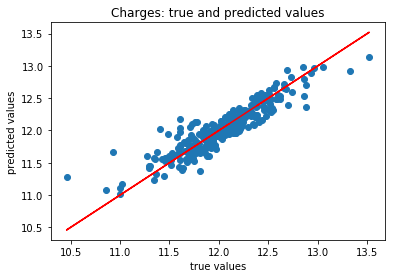

Mean absolute error of the prediction is: 0.12279998188942085
Mean squared error of the prediction is: 0.028083008119867397
Root mean squared error of the prediction is: 0.16757985594893976
Mean absolute percentage error of the prediction is: 1.0278655735562277


In [47]:
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


In [48]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))

R-squared of the model in the training set is: 0.8422493395566542
-----Test set statistics-----
R-squared of the model in the test set is: 0.8315817634876346


####  R squared remains at 84.2% and R adj squared is 84.1%. The differences between R squared in our train set and test set for this model is very little.  But same can be said for model 4. Both model shows that we do not have overfitting. Very little difference is seen in MEA, MSE, RMSE, and MAPE values when compared to model 4 but the values are still smaller.  All of our features are statistically significant. Initially I made the mistake of not dumming the variables int_rate and gdp_growth_rate. After using dummy variables, they became statistically significant. I can conclude that this model is better than model 4. 

In [49]:
#Reference for interest rates: https://www.multpl.com/us-real-gdp-growth-rate/table/by-year
#Reference for gdp_growth_rate: https://tradingeconomics.com/united-states/gdp-growth